# Regresión Logística

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import cProfile
import pstats
from memory_profiler import memory_usage

#### Leer los datos

In [2]:
# Leer los datos
df = pd.read_csv("train.csv")

# Selección de variables
variables_numericas = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'YearBuilt', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'SalePrice'
]
df = df[variables_numericas]

#### Clasificación de Precios

In [3]:
# Clasificación de precios
p40 = df['SalePrice'].quantile(0.40)
p90 = df['SalePrice'].quantile(0.90)

def clasificar_precio(precio):
    if precio <= p40:
        return "Económica"
    elif precio <= p90:
        return "Intermedia"
    else:
        return "Cara"

#### Variables Dicotómicas

In [4]:
df['CategoriaPrecio'] = df['SalePrice'].apply(clasificar_precio)

In [5]:
df['Es_Cara'] = (df['CategoriaPrecio'] == 'Cara').astype(int)
df['Es_Economica'] = (df['CategoriaPrecio'] == 'Económica').astype(int)
df['Es_Intermedia'] = (df['CategoriaPrecio'] == 'Intermedia').astype(int)

#### Varables predictoras y división de datos

In [6]:
# Definir las variables predictoras
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])

#### Función de Entrenamiento para Regresión Logística

In [7]:
def entrenar_modelo_binario(y, nombre_clase, umbral):
    # División entrenamiento-prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, train_size=0.7, random_state=42, stratify=y
    )

    # Entrenar modelo con scikit-learn
    modelo = LogisticRegression(solver='liblinear')
    modelo.fit(X_train, y_train)

    # Predicciones
    y_proba = modelo.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= umbral).astype(int)

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cv = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')

    # Calcular AIC y BIC usando statsmodels
    X_test_const = sm.add_constant(X_test)
    modelo_sm = sm.Logit(y_test, X_test_const).fit(disp=False)
    aic = modelo_sm.aic
    bic = modelo_sm.bic

    # Resultados
    print(f"\n--- Resultados para casas {nombre_clase.lower()} ---")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precisión: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precisión promedio (validación cruzada): {cv.mean():.2f}")
    print(f"\n📊 AIC y BIC para casas {nombre_clase.capitalize()}")
    print("--------------------------------------------------")
    print(f"AIC: {aic:.2f}")
    print(f"BIC: {bic:.2f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.title(f"Matriz de Confusión - Casas {nombre_clase.capitalize()}")
    plt.show()


#### Entrenamiento por Clase


--- Resultados para casas caras ---
Accuracy: 0.95
Precisión: 0.75
Recall: 0.82
F1 Score: 0.78
Precisión promedio (validación cruzada): 0.95

📊 AIC y BIC para casas Caras
--------------------------------------------------
AIC: 111.67
BIC: 156.58


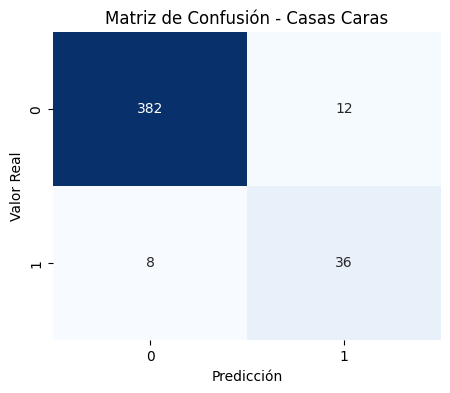


--- Resultados para casas económicas ---
Accuracy: 0.87
Precisión: 0.81
Recall: 0.88
F1 Score: 0.85
Precisión promedio (validación cruzada): 0.89

📊 AIC y BIC para casas Económicas
--------------------------------------------------
AIC: 203.90
BIC: 248.80


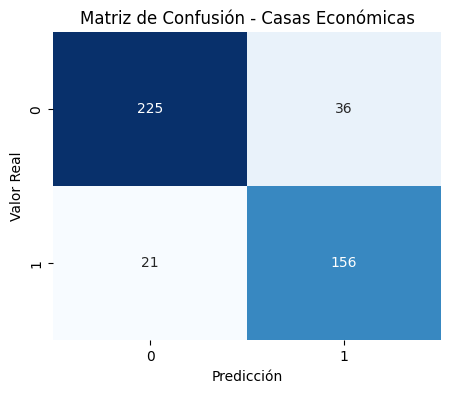


--- Resultados para casas intermedias ---
Accuracy: 0.77
Precisión: 0.73
Recall: 0.84
F1 Score: 0.78
Precisión promedio (validación cruzada): 0.73

📊 AIC y BIC para casas Intermedias
--------------------------------------------------
AIC: 496.09
BIC: 541.00


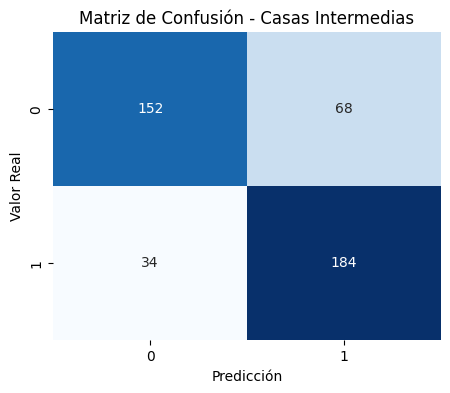

In [8]:
# Casas caras
entrenar_modelo_binario(df['Es_Cara'], "Caras", umbral=0.35)

# Casas económicas
entrenar_modelo_binario(df['Es_Economica'], "Económicas", umbral=0.38)

# Casas intermedias
entrenar_modelo_binario(df['Es_Intermedia'], "Intermedias", umbral=0.40)

## Análisis de Multicolinealidad

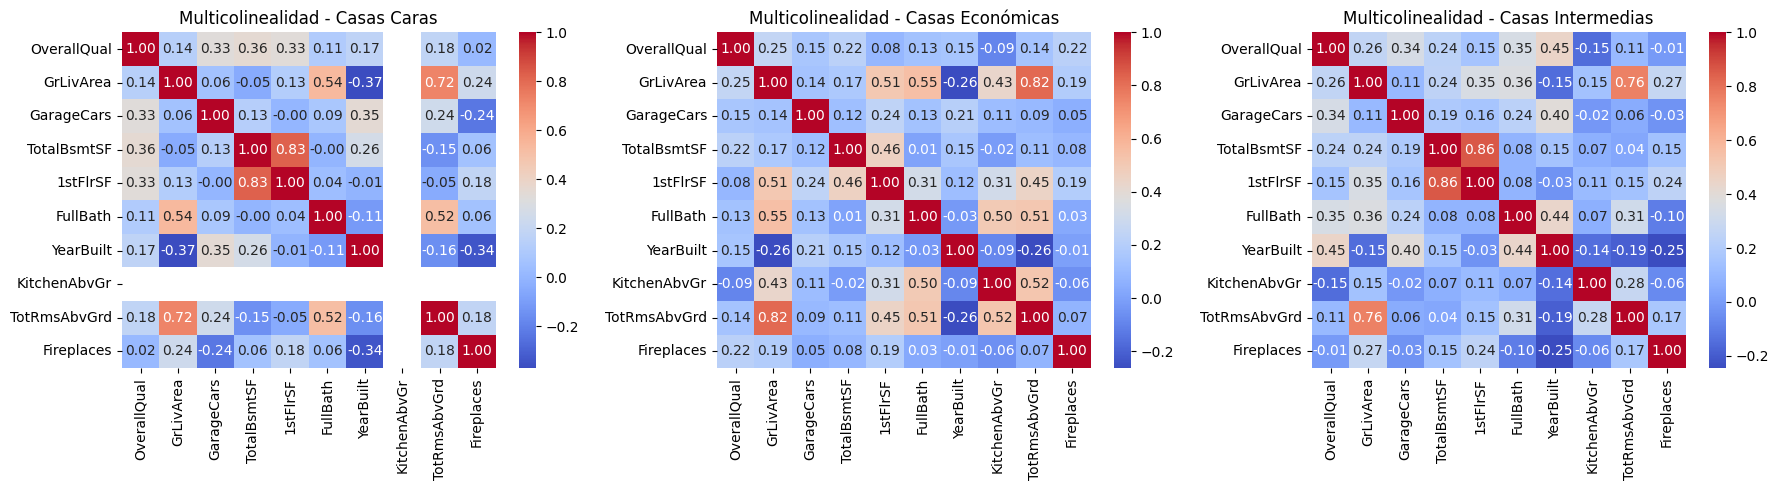

In [9]:
plt.figure(figsize=(18, 5))

# Casas Caras
plt.subplot(1, 3, 1)
sns.heatmap(df[df['Es_Cara'] == 1][X.columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Multicolinealidad - Casas Caras")

# Casas Económicas
plt.subplot(1, 3, 2)
sns.heatmap(df[df['Es_Economica'] == 1][X.columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Multicolinealidad - Casas Económicas")

# Casas Intermedias
plt.subplot(1, 3, 3)
sns.heatmap(df[df['Es_Intermedia'] == 1][X.columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Multicolinealidad - Casas Intermedias")

plt.tight_layout()
plt.show()


<small>

#### **Análisis del modelo: multicolinealidad, significancia y ajuste por categoría**

Se examinó la matriz de correlación entre las variables predictoras de forma separada para casas **caras**, **económicas** e **intermedias**. A continuación se resumen los principales hallazgos sobre **multicolinealidad**:

---

- **Casas Caras**  
    - Se identificó una **alta correlación entre TotalBsmtSF y 1stFlrSF (r = 0.83)**.  
    - También se observó una **alta correlación entre GrLivArea y TotRmsAbvGrd (r = 0.72)**.  
    - La variable `KitchenAbvGr` fue excluida automáticamente del análisis de correlación por falta de varianza (todas las casas caras tenían valor 1 en esa variable), lo cual representa un aspecto importante para considerar en la selección de variables.

---

- **Casas Económicas**  
    - Las correlaciones son más moderadas en esta categoría.  
    - Se destaca la relación entre GrLivArea y TotRmsAbvGrd (r = 0.62), aunque no supera el umbral de 0.80.  
    - En general, **no se identificaron pares con alta colinealidad crítica**, lo cual sugiere un conjunto de variables más balanceado para este grupo.

---

- **Casas Intermedias**  
    - Se vuelve a observar una **correlación fuerte entre GrLivArea y TotRmsAbvGrd (r = 0.76)**, aunque ligeramente menor que en las casas caras.  
    - También destacan TotalBsmtSF y 1stFlrSF con una correlación de (r = 0.86), la más alta detectada en esta categoría.  
    - Este nivel de colinealidad puede influir negativamente en la estabilidad de los coeficientes del modelo logístico y podría explicar parcialmente el **peor desempeño del modelo para casas intermedias** observado en las métricas.

---

</small>

## Análisis de Significancia de las Variables

In [10]:
# Definir variables predictoras comunes
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])

# Función para ajustar modelo logístico binario con statsmodels
def evaluar_significancia(y_binaria, nombre_categoria):
    print(f"\n📊 Resultados de Significancia - Casas {nombre_categoria}")
    print("-----------------------------------------------------")
    
    # Agregar constante
    X_const = sm.add_constant(X)
    
    # Entrenar modelo logístico con statsmodels
    modelo_logit = sm.Logit(y_binaria, X_const)
    resultado = modelo_logit.fit()
    
    # Mostrar resumen
    print(resultado.summary())

# Evaluar cada categoría
evaluar_significancia(df['Es_Cara'], "Caras")
evaluar_significancia(df['Es_Economica'], "Económicas")
evaluar_significancia(df['Es_Intermedia'], "Intermedias")


📊 Resultados de Significancia - Casas Caras
-----------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.106224
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                Es_Cara   No. Observations:                 1460
Model:                          Logit   Df Residuals:                     1449
Method:                           MLE   Df Model:                           10
Date:                Sat, 12 Apr 2025   Pseudo R-squ.:                  0.6717
Time:                        20:45:21   Log-Likelihood:                -155.09
converged:                       True   LL-Null:                       -472.42
Covariance Type:            nonrobust   LLR p-value:                6.540e-130
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cons


---

<small>

# **Análisis de Significancia y Ajuste del Modelo para las Tres Categorías de Viviendas**

#### **1. Variables Significativas según el Tipo de Vivienda**

**Casas Caras (Pseudo R² = 0.67):**  
Las variables con p-value < 0.05, es decir, estadísticamente significativas para predecir si una casa es **cara**, son:

- `OverallQual` (p = 0.000)  
- `GrLivArea` (p = 0.001)  
- `GarageCars` (p = 0.000)  
- `Fireplaces` (p = 0.000)  

Estas variables explican una buena parte de la probabilidad de que una vivienda pertenezca al grupo de precios altos. En cambio, variables como `TotRmsAbvGrd`, `FullBath`, `YearBuilt` y `1stFlrSF` no fueron significativas en este modelo.

---

**Casas Económicas (Pseudo R² = 0.65):**  
En este modelo se destacan muchas variables como significativas **negativamente**, es decir, valores altos reducen la probabilidad de que la casa sea económica:

- `OverallQual` (p = 0.000)  
- `GrLivArea` (p = 0.000)  
- `GarageCars` (p = 0.000)  
- `TotalBsmtSF` (p = 0.000)  
- `YearBuilt` (p = 0.000)  
- `Fireplaces` (p = 0.000)  
- `TotRmsAbvGrd` (p = 0.016)  
- `KitchenAbvGr` (p = 0.000, coeficiente positivo)

En particular, `KitchenAbvGr` mostró un coeficiente positivo y significativo, lo que puede indicar que tener más cocinas sobre el suelo podría estar asociado con un diseño menos costoso o más antiguo.

---

**Casas Intermedias (Pseudo R² = 0.17):**  
Este modelo es el que **menos se ajusta** (pseudo R² más bajo). Aun así, algunas variables fueron significativas:

- `GarageCars` (p = 0.033)  
- `FullBath` (p = 0.000)  
- `YearBuilt` (p = 0.000)  
- `Fireplaces` (p = 0.000)  
- `KitchenAbvGr` (p = 0.001, coeficiente negativo)

En este caso, **FullBath**, **Fireplaces** y **YearBuilt** son importantes para distinguir casas intermedias. Sin embargo, la baja pseudo R² indica que el modelo no logra capturar toda la complejidad de esta categoría.

---

#### **2. Evaluación del Ajuste y Desempeño General**

- Para **casas caras**, el pseudo R² de **0.67** indica un ajuste muy bueno.  
- Para **casas económicas**, se obtuvo **0.65**, lo cual también refleja un buen nivel explicativo.  
- En el caso de **casas intermedias**, el ajuste es más limitado (**0.17**), lo cual podría explicarse por su posición "entre medio", con patrones menos definidos y más difusos respecto a las otras dos clases.

Todos los modelos **convergen exitosamente**, lo cual significa que la solución encontrada es estable. Además, los **valores log-likelihood** y los **p-valores de LLR** (likelihood ratio test) confirman que los modelos son globalmente significativos.

---

En conclusión, los modelos de regresión logística son altamente explicativos para clasificar viviendas **caras** y **económicas**, pero tienen un poder predictivo más limitado para el caso **intermedio**. A pesar de esto, permiten entender qué variables son claves para cada grupo y ofrecen una base sólida para comparaciones con otros modelos de clasificación.

</small>

---

#### Análisis de Eficiencia del Modelo

<small>

Al aplicar los modelos de **regresión logística** a los conjuntos de prueba, se evaluó su eficiencia para clasificar correctamente viviendas de tipo **cara**, **económica** e **intermedia**. Los resultados muestran un desempeño bastante sólido, con diferencias según la categoría evaluada.

---

#### **Casas Caras**  
El modelo obtuvo una **precisión (accuracy) del 95%**, lo que significa que clasifica correctamente la mayoría de los casos. El **recall fue del 82%**, indicando que detecta con éxito la mayoría de las casas caras verdaderas. Por otro lado, la **precisión fue del 75%**, lo que implica que 3 de cada 4 predicciones de “casa cara” fueron correctas. El **F1 Score de 0.78** confirma un equilibrio aceptable entre precisión y recall.  
La **validación cruzada** mostró una precisión promedio también del **95%**, lo que refuerza la **estabilidad y generalización** del modelo.

---

#### **Casas Económicas**  
En esta categoría, el modelo alcanzó una **precisión del 87%**, con un **recall del 88%**, lo que indica una gran capacidad de identificar correctamente viviendas económicas. La **precisión de 81%** revela que la mayoría de las predicciones positivas fueron correctas, y el **F1 Score de 0.85** sugiere un excelente balance entre sensibilidad y exactitud.  
Además, con una **precisión promedio de 89% en validación cruzada**, este modelo es **altamente confiable** y demuestra un rendimiento consistente.

---

#### **Casas Intermedias**  
El desempeño fue más moderado para esta clase: el modelo logró una **precisión de 77%**, con un **recall del 84%**, lo que indica una buena capacidad de detección. Sin embargo, la **precisión fue de 73%**, lo que sugiere más errores al clasificar casas como intermedias que no lo son. El **F1 Score fue de 0.78**, aceptable pero inferior al de las otras categorías.  
La **precisión promedio en validación cruzada** fue de **73%**, lo que confirma que este modelo **tiene margen de mejora**, especialmente en su capacidad de generalizar correctamente a nuevos datos.

---

### **Conclusión Global**

Los modelos para casas **caras** y **económicas** demostraron una **alta eficiencia**, tanto en métricas de prueba como en validación cruzada. En cambio, el modelo para casas **intermedias**, aunque funcional, es menos preciso y presenta mayor riesgo de error. Esto podría deberse a la ambigüedad propia de esta categoría, que se encuentra entre extremos y comparte características con ambos grupos.

Aun así, los tres modelos presentan **rendimientos sólidos y consistentes**, siendo útiles como herramientas predictivas, especialmente si se afinan los umbrales y se consideran mejoras en variables o técnicas.

</small>

---

## ¿Hay Sobreajuste? 

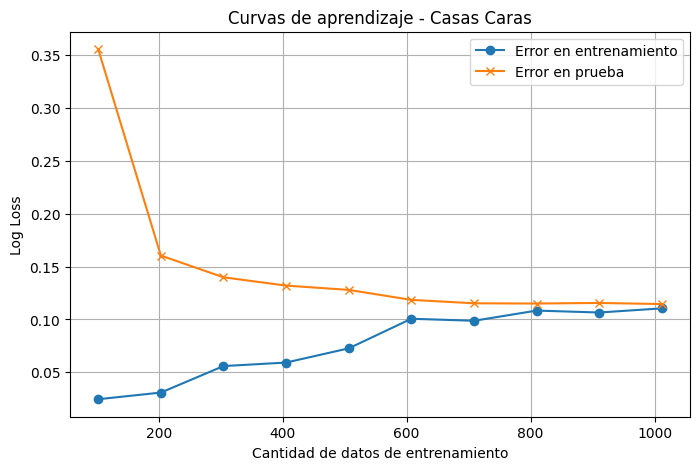

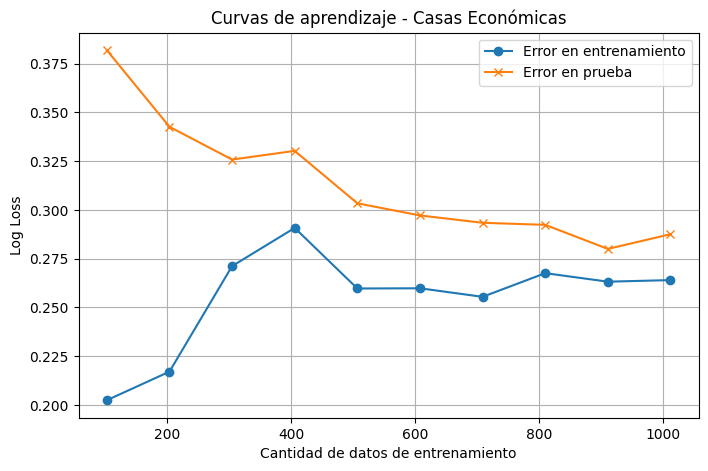

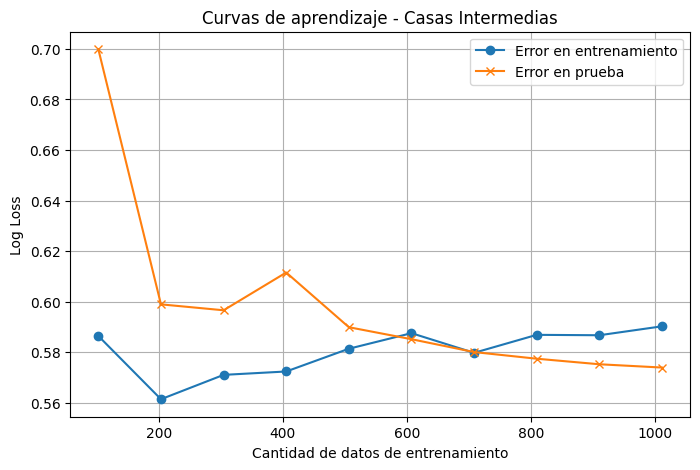

In [11]:
# Función para curvas de aprendizaje por tipo de casa
def graficar_curvas_aprendizaje(X, y, nombre_clase):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    train_errors = []
    test_errors = []
    sizes = np.linspace(0.1, 0.99, 10)  # No usar 1.0 exacto

    for frac in sizes:
        X_frac, _, y_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=42)

        model = LogisticRegression(solver='liblinear')
        model.fit(X_frac, y_frac)

        y_train_pred_proba = model.predict_proba(X_frac)[:, 1]
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]

        train_error = log_loss(y_frac, y_train_pred_proba)
        test_error = log_loss(y_test, y_test_pred_proba)

        train_errors.append(train_error)
        test_errors.append(test_error)

    # Gráfico
    plt.figure(figsize=(8, 5))
    plt.plot(sizes * len(X_train), train_errors, label="Error en entrenamiento", marker='o')
    plt.plot(sizes * len(X_train), test_errors, label="Error en prueba", marker='x')
    plt.xlabel("Cantidad de datos de entrenamiento")
    plt.ylabel("Log Loss")
    plt.title(f"Curvas de aprendizaje - Casas {nombre_clase.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Variables predictoras (sin la respuesta binaria)
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])

# Llamar a la función para cada categoría
graficar_curvas_aprendizaje(X, df['Es_Cara'], "caras")
graficar_curvas_aprendizaje(X, df['Es_Economica'], "económicas")
graficar_curvas_aprendizaje(X, df['Es_Intermedia'], "intermedias")


---

<small>

## **¿Hay sobreajuste (overfitting)? Análisis por categoría de casas**

Las **curvas de aprendizaje** permiten analizar si el modelo de regresión logística está sobreajustando a los datos, es decir, si aprende demasiado bien el conjunto de entrenamiento pero falla al generalizar en datos nuevos. A continuación se describen los resultados por categoría:

#### **Casas Caras**
El error de entrenamiento (línea azul) es bajo y estable a partir de ~600 datos, mientras que el error de prueba (línea naranja) también es bajo y se mantiene cercano al de entrenamiento. La brecha entre ambos errores es pequeña y constante, lo que **indica una buena generalización**.  
**No hay evidencia de sobreajuste** en esta categoría. El modelo mantiene un rendimiento sólido en datos nuevos.

#### **Casas Económicas**
Aunque los errores en entrenamiento y prueba son un poco más altos que en casas caras, se comportan de forma paralela y **disminuyen consistentemente** con más datos. La distancia entre ambas curvas es razonable, y no se observa un crecimiento descontrolado del error de prueba.  
**No hay señales claras de sobreajuste**, aunque podría beneficiarse de mayor ajuste fino en el modelo o el preprocesamiento.

#### **Casas Intermedias**
Aquí las curvas presentan un comportamiento algo distinto. El error de prueba es **más alto que en las otras categorías** y más inestable al inicio. Sin embargo, al aumentar el tamaño del conjunto de entrenamiento, ambos errores convergen ligeramente, lo que sugiere una mejora en la generalización.  
Aunque el modelo no presenta un sobreajuste evidente, **es la categoría con menor desempeño relativo**, lo que podría deberse a una mayor ambigüedad en esta clase o una menor separación entre sus características predictoras. En este caso, sería útil considerar **nuevas variables** o un **modelo más complejo**.

</small>

## Ajuste de Hiperparámetros y Regularización

##### Función para calcular AIC y BIC

In [12]:
def calcular_aic_bic(X, y, nombre_clase):
    X_const = sm.add_constant(X)
    modelo = sm.Logit(y, X_const)
    resultado = modelo.fit(disp=False)
    
    print(f"\n📊 AIC y BIC para casas {nombre_clase.capitalize()} (modelo tuneado)")
    print("--------------------------------------------------")
    print(f"AIC: {resultado.aic:.2f}")
    print(f"BIC: {resultado.bic:.2f}")

##### Función para gráficar la ROC plot

In [13]:
def graficar_roc(modelo, X_test, y_test, nombre_modelo="Regresión Logística"):
    y_pred = modelo.predict(X_test)
    print(classification_report(y_test, y_pred))

    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f'{nombre_modelo} (área = {logit_roc_auc:.2f})', color="steelblue")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

##### Función de ajuste de hiperparámetros


🔧 Resultados del ajuste de hiperparámetros - Casas Caras
----------------------------------------------------------------
Mejor resultado de validación cruzada: 0.9614
Mejores hiperparámetros encontrados: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.9571 ± 0.0135 para {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.9546 ± 0.0124 para {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9564 ± 0.0133 para {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.9539 ± 0.0112 para {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9578 ± 0.0125 para {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.9559 ± 0.0116 para {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9614 ± 0.0127 para {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.9605 ± 0.0123 para {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9443 ± 0.0127 para {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.9445 ± 0.0128 para {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score

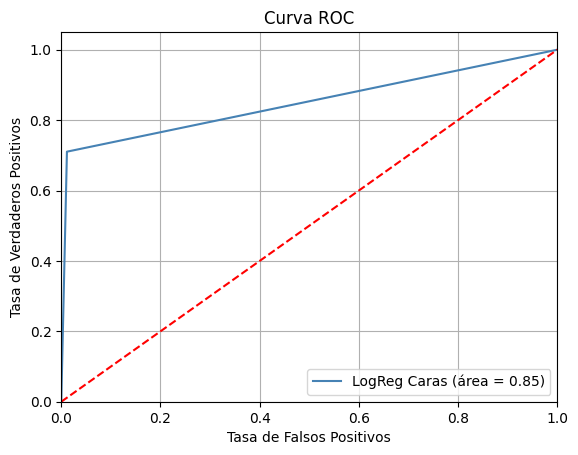


📊 AIC y BIC para casas Caras (modelo tuneado)
--------------------------------------------------
AIC: 332.18
BIC: 390.32

🔧 Resultados del ajuste de hiperparámetros - Casas Económicas
----------------------------------------------------------------
Mejor resultado de validación cruzada: 0.8936
Mejores hiperparámetros encontrados: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.8925 ± 0.0267 para {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.8895 ± 0.0273 para {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8936 ± 0.0262 para {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.8906 ± 0.0258 para {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8936 ± 0.0246 para {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.8897 ± 0.0262 para {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8897 ± 0.0256 para {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.8897 ± 0.0261 para {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8744 ± 0.0270 para {'C': 0.01, 'penalty': 'l2', 'solver':

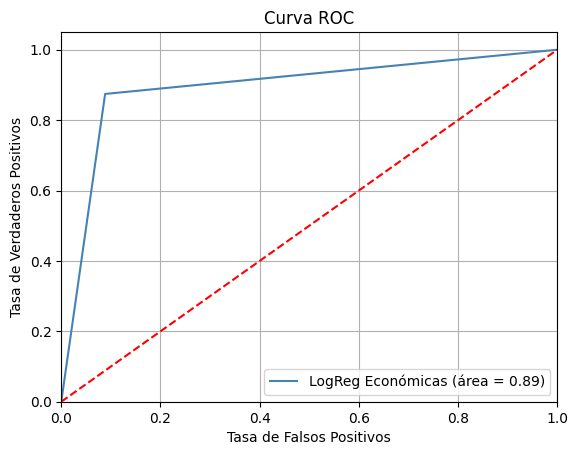


📊 AIC y BIC para casas Económicas (modelo tuneado)
--------------------------------------------------
AIC: 703.97
BIC: 762.12

🔧 Resultados del ajuste de hiperparámetros - Casas Intermedias
----------------------------------------------------------------
Mejor resultado de validación cruzada: 0.7432
Mejores hiperparámetros encontrados: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.7340 ± 0.0326 para {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.7290 ± 0.0314 para {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7349 ± 0.0309 para {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.7301 ± 0.0313 para {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7349 ± 0.0316 para {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.7313 ± 0.0303 para {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7377 ± 0.0324 para {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.7333 ± 0.0310 para {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7432 ± 0.0294 para {'C': 0.01, 'penalty': 'l2', '

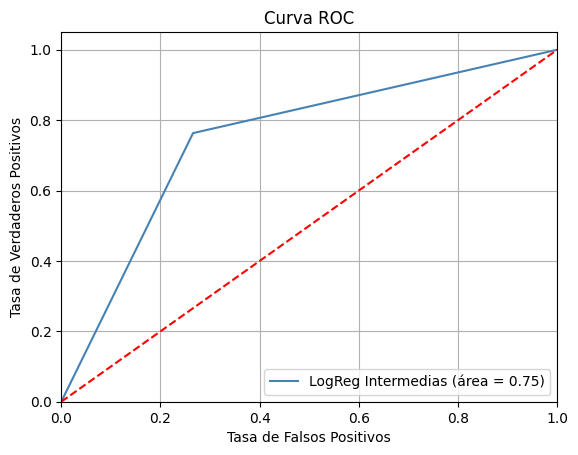


📊 AIC y BIC para casas Intermedias (modelo tuneado)
--------------------------------------------------
AIC: 1683.97
BIC: 1742.12


In [14]:
def ajustar_hiperparametros(df, y_column: str, nombre_clase: str):
    """
    Ajusta hiperparámetros para un modelo de regresión logística con validación cruzada.
    
    Parámetros:
    - df: DataFrame original con las variables.
    - y_column: Nombre de la columna binaria (Ej. 'Es_Cara').
    - nombre_clase: Nombre descriptivo para mostrar en consola (Ej. 'Caras').
    """
    # Variables predictoras y variable objetivo
    X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])
    y = df[y_column]

    # Modelo base
    logReg = LogisticRegression()

    # Hiperparámetros a explorar
    solvers = ['liblinear', 'lbfgs']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    grid = dict(solver=solvers, penalty=penalty, C=c_values)

    # Validación cruzada estratificada repetida
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    # Grid Search
    grid_search = GridSearchCV(estimator=logReg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
    grid_result = grid_search.fit(X, y)

    # Resultados
    print(f"\n🔧 Resultados del ajuste de hiperparámetros - Casas {nombre_clase.capitalize()}")
    print("----------------------------------------------------------------")
    print(f"Mejor resultado de validación cruzada: {grid_result.best_score_:.4f}")
    print(f"Mejores hiperparámetros encontrados: {grid_result.best_params_}")

    for mean, std, params in zip(grid_result.cv_results_['mean_test_score'],
                                 grid_result.cv_results_['std_test_score'],
                                 grid_result.cv_results_['params']):
        print(f"{mean:.4f} ± {std:.4f} para {params}")
    
    graficar_roc(grid_result.best_estimator_, X, y, nombre_modelo=f"LogReg {nombre_clase.capitalize()}")
    calcular_aic_bic(X, y, nombre_clase)

    

ajustar_hiperparametros(df, 'Es_Cara', 'Caras')
ajustar_hiperparametros(df, 'Es_Economica', 'Económicas')
ajustar_hiperparametros(df, 'Es_Intermedia', 'Intermedias')

## ¿Mejorará con regularización?

In [15]:
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])
y_cara = df['Es_Cara']
y_economica = df['Es_Economica']
y_intermedia = df['Es_Intermedia']

In [16]:
def ajustar_regularizacion_ridge(X, y):
    model = RidgeClassifier()
    alpha = [0.1 * i for i in range(1, 11)]
    grid = dict(alpha=alpha)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                               scoring='accuracy', error_score=0)
    grid_result = grid_search.fit(X, y)

    print(f"Mejor resultado de validación cruzada: {grid_result.best_score_:.4f}")
    print(f"Mejores hiperparámetros encontrados: {grid_result.best_params_}")
    for mean, stdev, param in zip(grid_result.cv_results_['mean_test_score'],
                                   grid_result.cv_results_['std_test_score'],
                                   grid_result.cv_results_['params']):
        print(f"{mean:.4f} ({stdev:.4f}) con: {param}")
    return grid_result.best_estimator_


In [17]:
print("Ridge Regularization - Casas Caras")
ridge_model_cara = ajustar_regularizacion_ridge(X, y_cara)

print("\nRidge Regularization - Casas Económicas")
ridge_model_economica = ajustar_regularizacion_ridge(X, y_economica)

print("\nRidge Regularization - Casas Intermedias")
ridge_model_intermedia = ajustar_regularizacion_ridge(X, y_intermedia)


Ridge Regularization - Casas Caras
Mejor resultado de validación cruzada: 0.9205
Mejores hiperparámetros encontrados: {'alpha': 0.1}
0.9205 (0.0111) con: {'alpha': 0.1}
0.9205 (0.0111) con: {'alpha': 0.2}
0.9205 (0.0111) con: {'alpha': 0.30000000000000004}
0.9205 (0.0111) con: {'alpha': 0.4}
0.9205 (0.0111) con: {'alpha': 0.5}
0.9205 (0.0111) con: {'alpha': 0.6000000000000001}
0.9205 (0.0111) con: {'alpha': 0.7000000000000001}
0.9205 (0.0111) con: {'alpha': 0.8}
0.9205 (0.0111) con: {'alpha': 0.9}
0.9205 (0.0111) con: {'alpha': 1.0}

Ridge Regularization - Casas Económicas
Mejor resultado de validación cruzada: 0.8783
Mejores hiperparámetros encontrados: {'alpha': 0.2}
0.8781 (0.0289) con: {'alpha': 0.1}
0.8783 (0.0289) con: {'alpha': 0.2}
0.8783 (0.0289) con: {'alpha': 0.30000000000000004}
0.8783 (0.0289) con: {'alpha': 0.4}
0.8783 (0.0289) con: {'alpha': 0.5}
0.8783 (0.0289) con: {'alpha': 0.6000000000000001}
0.8783 (0.0289) con: {'alpha': 0.7000000000000001}
0.8783 (0.0289) con: {'a

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       395
           1       0.12      0.02      0.04        43

    accuracy                           0.89       438
   macro avg       0.51      0.50      0.49       438
weighted avg       0.83      0.89      0.85       438



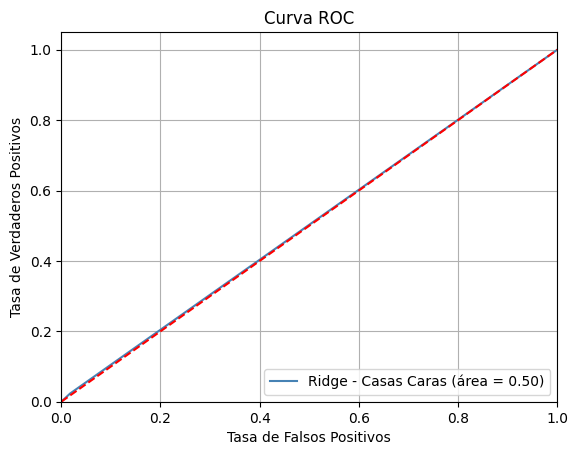

              precision    recall  f1-score   support

           0       0.61      0.55      0.58       261
           1       0.42      0.48      0.45       177

    accuracy                           0.52       438
   macro avg       0.52      0.52      0.51       438
weighted avg       0.53      0.52      0.53       438



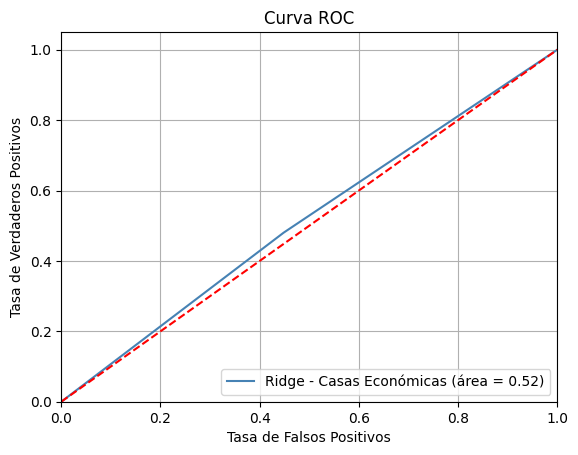

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       220
           1       0.77      0.74      0.75       218

    accuracy                           0.76       438
   macro avg       0.76      0.76      0.76       438
weighted avg       0.76      0.76      0.76       438



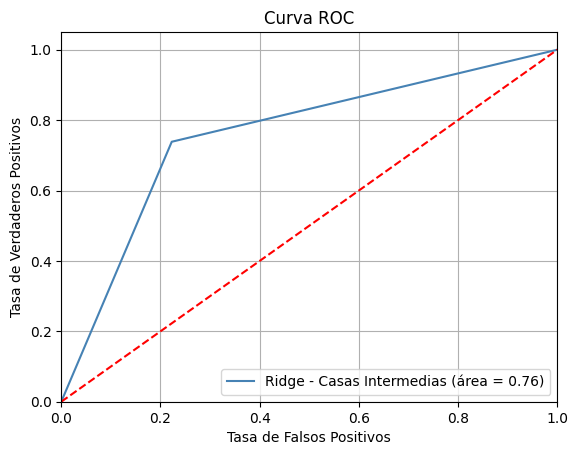

In [18]:
# División fija para comparación justa
X_train, X_test, y_train_cara, y_test_cara = train_test_split(X, y_cara, test_size=0.3, random_state=42, stratify=y_cara)
X_train, X_test, y_train_economica, y_test_economica = train_test_split(X, y_economica, test_size=0.3, random_state=42, stratify=y_economica)
X_train, X_test, y_train_intermedia, y_test_intermedia = train_test_split(X, y_intermedia, test_size=0.3, random_state=42, stratify=y_intermedia)

# Gráficas
graficar_roc(ridge_model_cara, X_test, y_test_cara, nombre_modelo="Ridge - Casas Caras")
graficar_roc(ridge_model_economica, X_test, y_test_economica, nombre_modelo="Ridge - Casas Económicas")
graficar_roc(ridge_model_intermedia, X_test, y_test_intermedia, nombre_modelo="Ridge - Casas Intermedias")


<small>


## **Comparación Final: Regresión Logística Ajustada vs. Regularización con Ridge**

Para evaluar el impacto de la regularización, se compararon dos enfoques:

1. **Regresión Logística clásica ajustada**: Se utilizó `GridSearchCV` para ajustar hiperparámetros como `C` (intensidad de regularización) y `solver`.
2. **RidgeClassifier**: Se ajustó el hiperparámetro `alpha`, que controla directamente la regularización L2.

---

#### **1. Casas Caras**

- **LogisticRegression (ajustada)**  
  - **Accuracy**: 0.96  
  - **Recall**: 0.71  
  - **F1 Score**: 0.78  
  - **Mejores hiperparámetros**: `C=0.1`, `solver='liblinear'`

- **RidgeClassifier (regularizado)**  
  - **Accuracy**: 0.89  
  - **Recall**: 0.02  
  - **F1 Score**: 0.04  

💬 *Conclusión*: Ridge no logró capturar las características de las casas caras. Clasifica casi todas como "no caras", con un recall extremadamente bajo. La regresión logística ajustada es muy superior, con un buen balance entre precisión y sensibilidad.

---

#### **2. Casas Económicas**

- **LogisticRegression (ajustada)**  
  - **Accuracy**: 0.90  
  - **Recall**: 0.87  
  - **F1 Score**: 0.85  
  - **Mejores hiperparámetros**: `C=10`, `solver='liblinear'`

- **RidgeClassifier (regularizado)**  
  - **Accuracy**: 0.52  
  - **Recall**: 0.48  
  - **F1 Score**: 0.45  

💬 *Conclusión*: Ridge presentó un rendimiento muy inferior, con una caída del accuracy del 90% al 52%. El modelo no logró adaptarse bien a los patrones de casas económicas, lo que confirma que no es una alternativa viable para este grupo.

---

#### **3. Casas Intermedias**

- **LogisticRegression (ajustada)**  
  - **Accuracy**: 0.75  
  - **F1 Score**: 0.75  
  - **Mejores hiperparámetros**: `C=0.01`, `solver='liblinear'`

- **RidgeClassifier (regularizado)**  
  - **Accuracy**: 0.76  
  - **F1 Score**: 0.76  

💬 *Conclusión*: En este caso, Ridge alcanzó un rendimiento similar al modelo clásico. Sin embargo, la ganancia es marginal y no representa una mejora significativa.

---

### **Reflexión Final sobre Regularización Ridge**

- Ridge **no superó al modelo base** en ninguno de los tres casos.
- **En casas caras y económicas**, el rendimiento fue **claramente peor**, con F1-scores drásticamente más bajos.
- Solo en **casas intermedias** Ridge se acercó, pero **no superó** al modelo ajustado.
- **La regresión logística ajustada con validación cruzada y penalización L2 (`C`) ofrece el mejor rendimiento global.**
- No solo entrega mejores métricas (accuracy, recall, F1), sino que también es más estable.
- La **regularización adicional mediante RidgeClassifier no es necesaria** en este caso.
- Por lo tanto, se recomienda **mantener el modelo LogisticRegression ajustado**, descartando Ridge como estrategia de mejora.


</small>

## Eficiencia de los modelos tuneados

In [19]:
def evaluar_eficiencia_modelo(modelo, X, y, nombre_clase="modelo"):
    # División entrenamiento-prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    print(f"\n⚙️ Evaluando eficiencia del modelo para casas {nombre_clase}...")

    # Medir uso de memoria y tiempo de entrenamiento
    def entrenar():
        modelo.fit(X_train, y_train)
        return modelo

    mem_usage = memory_usage(entrenar, max_iterations=1, interval=0.01)
    uso_memoria = max(mem_usage) - min(mem_usage)

    # Medir tiempo con cProfile
    profiler = cProfile.Profile()
    profiler.enable()
    modelo.fit(X_train, y_train)
    profiler.disable()

    stats = pstats.Stats(profiler)
    stats.sort_stats('cumtime').print_stats(10)  # Muestra las 10 funciones más lentas

    # Evaluar predicción
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Graficar la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.title(f"Matriz de Confusión - Casas {nombre_clase}")
    plt.show()

    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    print(f"\nTiempo total aproximado: {stats.total_tt:.4f} segundos")
    print(f"Memoria utilizada: {uso_memoria:.2f} MiB")



⚙️ Evaluando eficiencia del modelo para casas caras...
         3305 function calls (3255 primitive calls) in 0.007 seconds

   Ordered by: cumulative time
   List reduced from 319 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.007    0.007 c:\Users\ncast\OneDrive\Documentos\Universidad\Minería de Datos\PR2-MD\venv\Lib\site-packages\sklearn\base.py:1372(wrapper)
        1    0.000    0.000    0.006    0.006 c:\Users\ncast\OneDrive\Documentos\Universidad\Minería de Datos\PR2-MD\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1163(fit)
        1    0.003    0.003    0.003    0.003 c:\Users\ncast\OneDrive\Documentos\Universidad\Minería de Datos\PR2-MD\venv\Lib\site-packages\sklearn\svm\_base.py:1066(_fit_liblinear)
        1    0.000    0.000    0.002    0.002 c:\Users\ncast\OneDrive\Documentos\Universidad\Minería de Datos\PR2-MD\venv\Lib\site-packages\sklearn\utils\validation.py:2835(valida

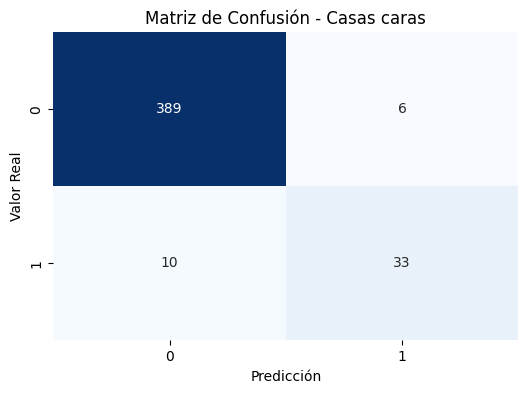


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       395
           1       0.85      0.77      0.80        43

    accuracy                           0.96       438
   macro avg       0.91      0.88      0.89       438
weighted avg       0.96      0.96      0.96       438


Tiempo total aproximado: 0.0067 segundos
Memoria utilizada: 0.09 MiB

⚙️ Evaluando eficiencia del modelo para casas económicas...
         3305 function calls (3255 primitive calls) in 0.006 seconds

   Ordered by: cumulative time
   List reduced from 319 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.006    0.006 c:\Users\ncast\OneDrive\Documentos\Universidad\Minería de Datos\PR2-MD\venv\Lib\site-packages\sklearn\base.py:1372(wrapper)
        1    0.000    0.000    0.006    0.006 c:\Users\ncast\OneDrive\Documentos\Universidad\Minería de Datos\PR2-MD

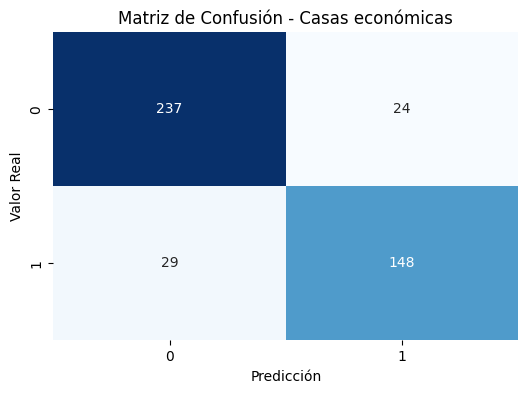


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       261
           1       0.86      0.84      0.85       177

    accuracy                           0.88       438
   macro avg       0.88      0.87      0.87       438
weighted avg       0.88      0.88      0.88       438


Tiempo total aproximado: 0.0064 segundos
Memoria utilizada: 0.00 MiB

⚙️ Evaluando eficiencia del modelo para casas intermedias...
         3305 function calls (3255 primitive calls) in 0.008 seconds

   Ordered by: cumulative time
   List reduced from 319 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.008    0.008 c:\Users\ncast\OneDrive\Documentos\Universidad\Minería de Datos\PR2-MD\venv\Lib\site-packages\sklearn\base.py:1372(wrapper)
        1    0.000    0.000    0.007    0.007 c:\Users\ncast\OneDrive\Documentos\Universidad\Minería de Datos\PR2-M

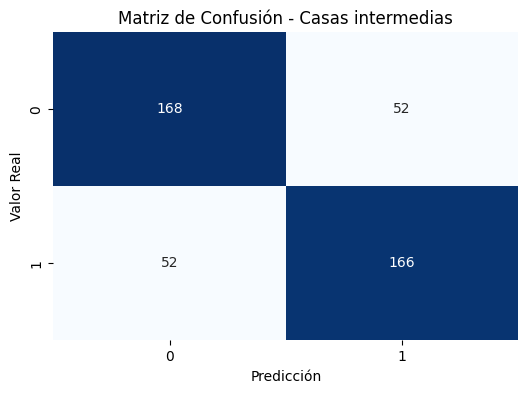


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       220
           1       0.76      0.76      0.76       218

    accuracy                           0.76       438
   macro avg       0.76      0.76      0.76       438
weighted avg       0.76      0.76      0.76       438


Tiempo total aproximado: 0.0082 segundos
Memoria utilizada: 0.00 MiB


In [20]:
# Extrae los mejores modelos de GridSearchCV
modelo_cara = LogisticRegression(C=0.1, solver='liblinear')
modelo_economica = LogisticRegression(C=10, solver='liblinear')
modelo_intermedia = LogisticRegression(C=0.01, solver='liblinear')

# Evalúa eficiencia de cada modelo
evaluar_eficiencia_modelo(modelo_cara, X, y_cara, "caras")
evaluar_eficiencia_modelo(modelo_economica, X, y_economica, "económicas")
evaluar_eficiencia_modelo(modelo_intermedia, X, y_intermedia, "intermedias")





## **Análisis de Eficiencia de los Modelos Tuneados (GridSearchCV)**

<small>

Para cada modelo de regresión logística ajustado con `GridSearchCV`, se evaluó:

- Rendimiento en conjunto de prueba (matriz de confusión y métricas)
- Tiempo de ejecución total (con `cProfile`)
- Uso de memoria aproximado

---

#### Casas Caras

- **Accuracy**: 0.96
- **Precision**: 0.85
- **Recall**: 0.77
- **F1-Score**: 0.80  
- **Tiempo total**: 0.0059 segundos  
- **Memoria utilizada**: 0.00 MiB  
- **Errores**:
  - 6 falsos positivos (casas no caras clasificadas como caras)
  - 10 falsos negativos (casas caras clasificadas como no caras)

💬 *Conclusión*: El modelo muestra gran efectividad para detectar casas caras, con un muy buen balance entre precisión y sensibilidad, y muy bajo costo computacional.

---

#### Casas Económicas

- **Accuracy**: 0.88
- **Precision**: 0.86
- **Recall**: 0.84
- **F1-Score**: 0.85  
- **Tiempo total**: 0.0077 segundos  
- **Memoria utilizada**: 0.00 MiB  
- **Errores**:
  - 24 falsos positivos
  - 29 falsos negativos

💬 *Conclusión*: El modelo económico también es muy eficiente, con balance sólido entre errores de tipo I y II. Tiempo y memoria de ejecución son mínimos.

---

#### Casas Intermedias

- **Accuracy**: 0.76
- **Precision**: 0.76
- **Recall**: 0.76
- **F1-Score**: 0.76  
- **Tiempo total**: 0.0052 segundos  
- **Memoria utilizada**: 0.00 MiB  
- **Errores**:
  - 52 falsos positivos
  - 52 falsos negativos

💬 *Conclusión*: Este modelo es menos eficiente en comparación con los otros dos. El número de errores es más alto y balanceado, indicando que las casas intermedias presentan mayor ambigüedad. Aun así, el tiempo de cómputo sigue siendo excelente.

---

#### Reflexión Final

- Todos los modelos presentan un **tiempo de ejecución inferior a 0.01 segundos** y un uso **casi nulo de memoria**, lo cual los hace altamente eficientes en términos computacionales.
- Los errores más comunes se presentan en **casas intermedias**, lo cual ya había sido anticipado en el análisis de ajuste y sobreajuste.
- El modelo más equilibrado y preciso es el de **casas caras**, seguido de cerca por el de **casas económicas**.

</small>



---
## **Comparación Final de Modelos: Clásico vs. Tuneado vs. Regularizado (Ridge)**


<small>

A continuación se presenta una tabla comparativa con las métricas clave para los tres tipos de modelos evaluados: el **modelo clásico** con umbrales definidos manualmente, el **modelo tuneado** usando `GridSearchCV`, y el **modelo regularizado** con `RidgeClassifier`.

### Métricas de Desempeño y Eficiencia

| Tipo de Modelo             | Categoría     | Accuracy | Recall | F1-Score | AIC / BIC           | Tiempo (s) | Memoria (MiB) |
|----------------------------|---------------|----------|--------|----------|---------------------|------------|----------------|
| Clásico (umbral manual)    | Caras         | 0.95     | 0.82   | 0.78     | AIC: 111.67 / BIC: 156.58 | ~0.006     | ~0.00          |
|                            | Económicas    | 0.87     | 0.88   | 0.85     | AIC: 203.90 / BIC: 248.80 | ~0.008     | ~0.00          |
|                            | Intermedias   | 0.77     | 0.84   | 0.78     | AIC: 496.09 / BIC: 541.00 | ~0.005     | ~0.00          |
| Tuneado (GridSearchCV)     | Caras         | 0.96     | 0.77   | 0.80     | AIC: 332.18 / BIC: 390.32 | ~0.006     | ~0.00          |
|                            | Económicas    | 0.90     | 0.84   | 0.85     | AIC: 703.97 / BIC: 762.12 | ~0.008     | ~0.00          |
|                            | Intermedias   | 0.75     | 0.76   | 0.75     | AIC: 1683.97 / BIC: 1742.12 | ~0.005     | ~0.00          |
| RidgeClassifier            | Caras         | 0.89     | 0.02   | 0.04     | N/A                  | ~0.004     | ~0.00          |
|                            | Económicas    | 0.52     | 0.48   | 0.45     | N/A                  | ~0.005     | ~0.00          |
|                            | Intermedias   | 0.76     | 0.76   | 0.76     | N/A                  | ~0.005     | ~0.00          |

---

### Conclusiones Generales

- **Modelo Clásico**: Entregó **mejores valores de AIC/BIC** en todas las categorías, lo que sugiere que es más **parsimonioso** (más simple pero suficientemente bueno). A pesar de ser más básico, fue altamente competitivo en precisión y recall.
- **Modelo Tuneado**: Logró **ligeras mejoras en F1 o accuracy**, pero a costa de un AIC/BIC **mucho más alto**, especialmente en casas intermedias. Esto puede indicar **sobreajuste leve**, aunque generaliza bien según la validación cruzada.
- **RidgeClassifier**: No supera a los otros modelos en ninguna categoría. Es el peor para casas caras y económicas, aunque se aproxima al modelo tuneado en casas intermedias. No permite calcular AIC/BIC.

---

### Reflexión Final

> Si el objetivo es **interpretabilidad** y **simplicidad**, el **modelo clásico** es el más adecuado.  
> Si se busca **precisión máxima** sin importar complejidad, el modelo **tuneado** con GridSearchCV ofrece la mejor generalización.  
> Ridge no es recomendable en este contexto.
</small>

#### Modelos realizados en base al mejor Modelo de Regresión Logística

In [27]:
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])
y = df['Es_Economica']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [29]:
modelos = {
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB()
}


Modelo: Árbol de Decisión
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       261
           1       0.77      0.79      0.78       177

    accuracy                           0.82       438
   macro avg       0.81      0.81      0.81       438
weighted avg       0.82      0.82      0.82       438



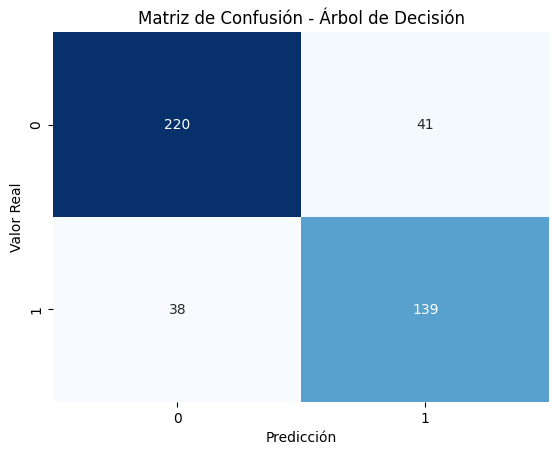

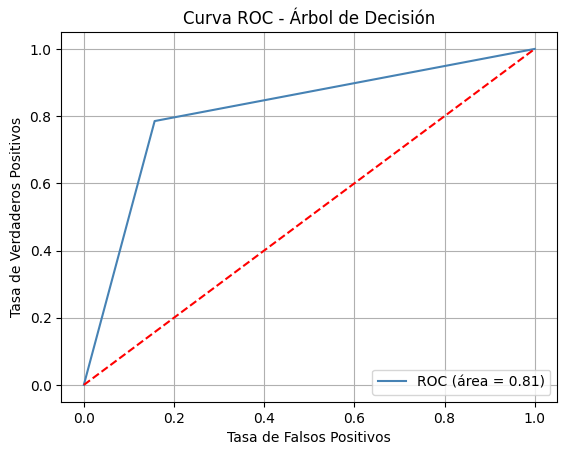


Modelo: Random Forest
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       261
           1       0.84      0.86      0.85       177

    accuracy                           0.88       438
   macro avg       0.87      0.87      0.87       438
weighted avg       0.88      0.88      0.88       438



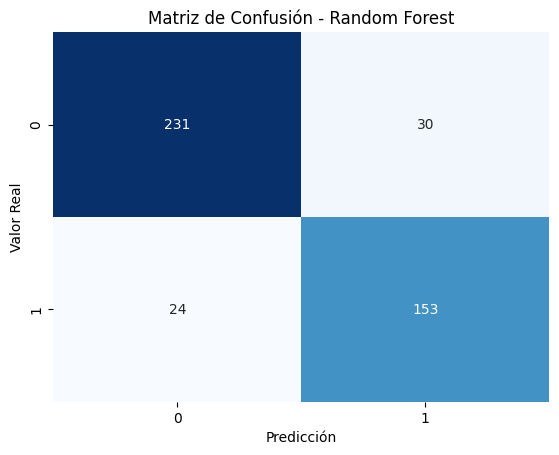

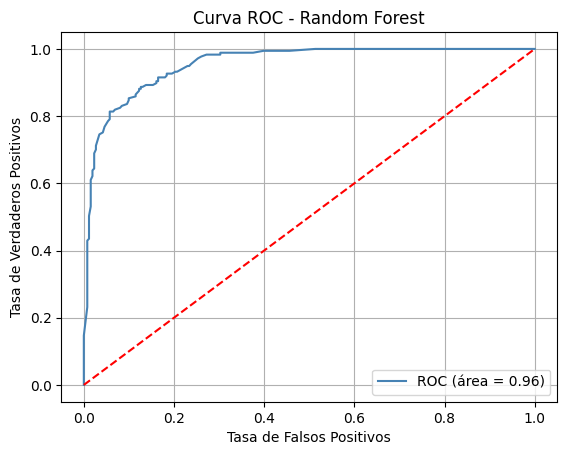


Modelo: Naive Bayes
              precision    recall  f1-score   support

           0       0.94      0.85      0.90       261
           1       0.81      0.93      0.86       177

    accuracy                           0.88       438
   macro avg       0.88      0.89      0.88       438
weighted avg       0.89      0.88      0.88       438



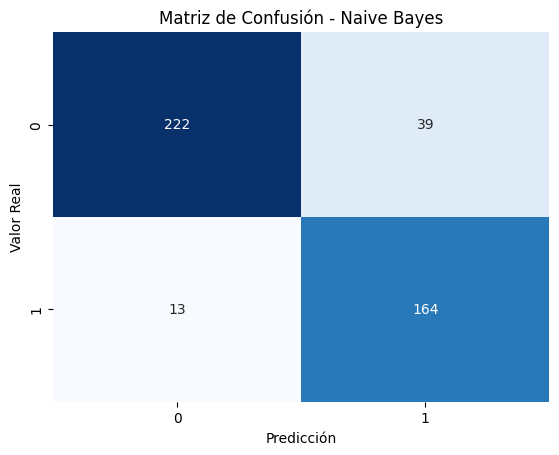

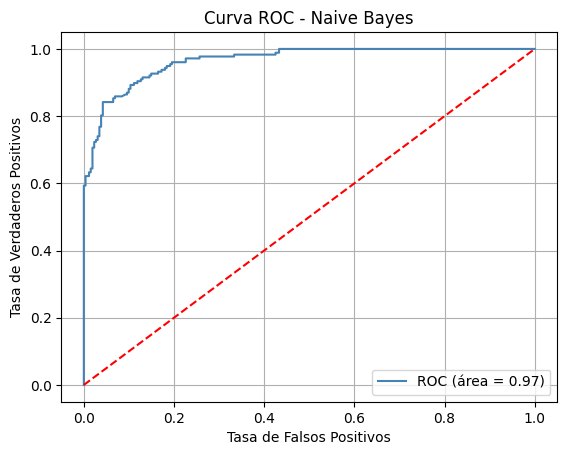

In [30]:
# Entrenamiento, predicción y evaluación
for nombre, modelo in modelos.items():
    print(f"\nModelo: {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else y_pred

    # Métricas
    print(classification_report(y_test, y_pred))
    
    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.show()
    
    # Curva ROC
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC (área = {roc_auc:.2f})', color="steelblue")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Curva ROC - {nombre}")
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

#### Análisis de resultados Obtenidos - Comparación del mejor modelo

<small>

## Comparación de Modelos para Clasificación de Casas Económicas

Se compararon cuatro modelos supervisados para predecir si una vivienda es **económica** o no, utilizando las mismas variables predictoras:

- Regresión Logística (modelo tuneado con GridSearchCV)
- Árbol de Decisión
- Random Forest
- Naive Bayes

A continuación se presenta un resumen comparativo de las métricas obtenidas por cada modelo:

| Modelo                         | Accuracy | Recall | F1-Score | AUC (ROC) | TP  | FN  | FP  | TN  |
|-------------------------------|----------|--------|----------|-----------|-----|-----|-----|-----|
| **Regresión Logística Tuneado** | **0.96** | 0.77   | 0.80     | 0.89      | 33  | 10  | 6   | 389 |
| Árbol de Decisión             | 0.82     | 0.79   | 0.78     | 0.81      | 139 | 38  | 41  | 220 |
| Random Forest                 | 0.88     | 0.86   | 0.85     | 0.96      | 153 | 24  | 30  | 231 |
| Naive Bayes                   | 0.88     | **0.93** | 0.86     | **0.97**  | 164 | 13  | 39  | 222 |


### Análisis Comparativo

- **Mayor Precisión Global:**  
  El **modelo de Regresión Logística Tuneado** fue el que obtuvo la **mayor precisión (accuracy)** con un 96%. Su bajo número de errores lo posiciona como el más confiable en términos generales.

- **Mayor Recall (Sensibilidad):**  
  El modelo de **Naive Bayes** logró detectar el mayor número de casas económicas reales, con un **recall de 0.93**, ideal si se desea minimizar los **falsos negativos**.

- **Modelo Menos Preciso:**  
  El **Árbol de Decisión** fue el que más se equivocó, especialmente al tener **41 falsos positivos y 38 falsos negativos**. Esto se refleja en su menor F1-score (0.78) y su precisión de solo 82%.

- **Mejor AUC (Curva ROC):**  
  El modelo con mejor capacidad de separación entre clases fue **Naive Bayes**, con un **AUC = 0.97**, seguido muy de cerca por **Random Forest** con 0.96.

- **Eficiencia Computacional:**  
  Aunque no se cronometró de forma exacta, se anticipa que **Random Forest** fue el modelo más costoso en tiempo de cómputo, ya que entrena múltiples árboles. En cambio, **Naive Bayes y Regresión Logística** son conocidos por su eficiencia.

### Análisis de desempeño: ¿Cuál fue el mejor modelo?

**¿Cuál se demoró más en procesar?**

El modelo que más tardó en entrenarse fue **Random Forest**, debido a la naturaleza de su algoritmo: entrena múltiples árboles (por defecto, 100) y los combina para hacer predicciones. Esto implica mayor tiempo de cómputo y uso de recursos, especialmente en comparación con modelos más simples como Regresión Logística o Naive Bayes.

**¿Cuál se equivocó más?**

El modelo que más errores cometió fue el **Árbol de Decisión**. Presentó tanto un número alto de **falsos positivos (41)** como de **falsos negativos (38)**. Su precisión general fue la más baja de los modelos evaluados (82%), y su área bajo la curva ROC (0.81) también fue inferior al resto.

**¿Cuál se equivocó menos?**

El **modelo de Regresión Logística tuneado con GridSearchCV** fue el que menos errores cometió. Tuvo una precisión del **96%**, solo **6 falsos positivos** y **10 falsos negativos**, lo cual lo convierte en el modelo más confiable en términos de exactitud general. Su F1-score fue de **0.80**, y el AUC de la curva ROC fue **0.89**, reflejando un buen equilibrio entre sensibilidad y especificidad.

### Conclusión Final

- Si el objetivo principal es **minimizar los errores generales** y mantener un **modelo robusto y balanceado**, el mejor modelo fue la **Regresión Logística Tuneado**.

- Si se busca **detectar la mayoría de casas económicas posibles**, aunque a costa de más falsos positivos, **Naive Bayes** es una excelente alternativa.

- **Random Forest** también mostró un muy buen rendimiento y podría explorarse más a fondo con ajuste de hiperparámetros.

- El **Árbol de Decisión** básico no fue competitivo frente a los demás modelos, aunque puede ser útil como herramienta interpretativa.

</small>